# Imports

In [ ]:
!pip install pytorch-ignite

In [ ]:
!unzip reddit_memes_dataset.npy.zip

In [1]:
!rm -r tmp/

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms as T
from torchvision import utils as vutils
from torch.utils.data.dataset import Dataset
from torch.utils import data
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint, Timer
from ignite.metrics import RunningAverage

# Network Architecture
Taken from:
https://github.com/pytorch/ignite/blob/master/examples/gan/dcgan.py

In [3]:
class Net(torch.nn.Module):
    """ A base class for both generator and the discriminator.
    Provides a common weight initialization scheme.
    """
    def weights_init(self):
        for m in self.modules():
            classname = m.__class__.__name__
            if "Conv" in classname:
                m.weight.data.normal_(0.0, 0.02)
            elif "BatchNorm" in classname:
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)

    def forward(self, x):
        return x

In [4]:
class Generator(Net):
    """ Generator network.
    Args:
        nf (int): Number of filters in the second-to-last deconv layer
    """
    def __init__(self, z_dim, nf, nc):
        super(Generator, self).__init__()
        self.net = torch.nn.Sequential(
            # input is Z, going into a convolution
            torch.nn.ConvTranspose2d(in_channels=z_dim, out_channels=nf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            torch.nn.BatchNorm2d(nf * 8),
            torch.nn.ReLU(inplace=True),
            # state size. (nf*8) x 4 x 4
            torch.nn.ConvTranspose2d(in_channels=nf * 8, out_channels=nf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(nf * 4),
            torch.nn.ReLU(inplace=True),
            # state size. (nf*4) x 8 x 8
            torch.nn.ConvTranspose2d(in_channels=nf * 4, out_channels=nf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(nf * 2),
            torch.nn.ReLU(inplace=True),
            # state size. (nf*2) x 16 x 16
            torch.nn.ConvTranspose2d(in_channels=nf * 2, out_channels=nf, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(nf),
            torch.nn.ReLU(inplace=True),
            # state size. (nf) x 32 x 32
            torch.nn.ConvTranspose2d(in_channels=nf, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
            # state size. (nc) x 64 x 64
        )
        self.weights_init()

    def forward(self, x):
        return self.net(x)

In [5]:
class Discriminator(Net):
    """ Discriminator network.
    Args:
        nf (int): Number of filters in the first conv layer.
    """
    def __init__(self, nc, nf):
        super(Discriminator, self).__init__()
        self.net = torch.nn.Sequential(
            # input is (nc) x 64 x 64
            torch.nn.Conv2d(in_channels=nc, out_channels=nf, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (nf) x 32 x 32
            torch.nn.Conv2d(in_channels=nf, out_channels=nf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(nf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (nf*2) x 16 x 16
            torch.nn.Conv2d(in_channels=nf * 2, out_channels=nf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(nf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (nf*4) x 8 x 8
            torch.nn.Conv2d(in_channels=nf * 4, out_channels=nf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(nf * 8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (nf*8) x 4 x 4
            torch.nn.Conv2d(in_channels=nf * 8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            torch.nn.Sigmoid(),
        )
        self.weights_init()

    def forward(self, x):
        output = self.net(x)
        return output.view(-1, 1).squeeze(1)

# Training

Hyperparameters

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 127
alpha = 0.98  # Smoothing constant for exponential moving averages
num_channels = 3  # Number of image channels
z_dim = 100  # Size of latent z vector
g_filters = 64  # Number of filters in the second-to-last generator deconv layer
d_filters = 64  # Number of filters in first discriminator conv layer
learning_rate = 0.0002
FAKE_IMG_FNAME = 'fake_sample_epoch_{:04d}.png'
REAL_IMG_FNAME = 'real_sample_epoch_{:04d}.png'
LOGS_FNAME = 'logs.tsv'
PLOT_FNAME = 'plot.svg'
SAMPLES_FNAME = 'samples.svg'
output_dir = 'tmp'
epochs = 2500

Set-up

In [7]:
class CustomDataset(Dataset):
    def __init__(self, tensors):
        self.data = tensors

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [8]:
dataset = CustomDataset(torch.tensor(np.load('reddit_memes_dataset.npy')))
loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

netG = Generator(z_dim, g_filters, num_channels).to(device)
netD = Discriminator(num_channels, d_filters).to(device)

bce = torch.nn.BCELoss()

optimizerG = torch.optim.AdamW(netG.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizerD = torch.optim.AdamW(netD.parameters(), lr=learning_rate, betas=(0.5, 0.999))

real_labels = torch.ones(batch_size, device=device)
fake_labels = torch.zeros(batch_size, device=device)
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)

In [9]:
def get_noise():
    return torch.randn(batch_size, z_dim, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


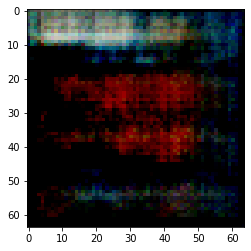

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


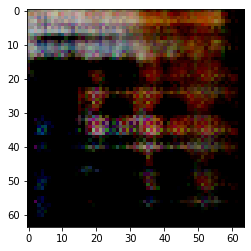

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


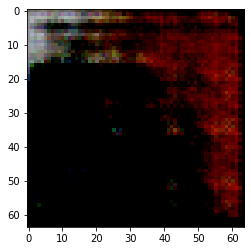

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


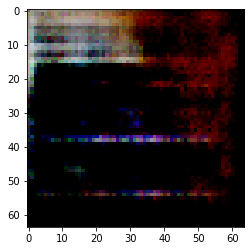

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


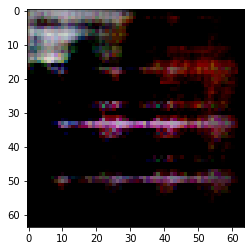

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


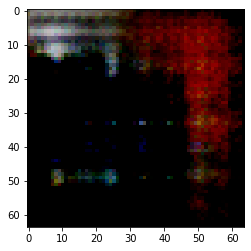

Engine run is terminating due to exception: .


NameError: ignored

In [14]:
# The main function, processing a batch of examples
def step(engine, real):
    real = real.to(device)

    # -----------------------------------------------------------
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    netD.zero_grad()

    # train with real
    output = netD(real)
    errD_real = bce(output, real_labels)
    D_x = output.mean().item()

    errD_real.backward()

    # get fake image from generator
    noise = get_noise()
    fake = netG(noise)

    # train with fake
    output = netD(fake.detach())
    errD_fake = bce(output, fake_labels)
    D_G_z1 = output.mean().item()

    errD_fake.backward()

    # gradient update
    errD = errD_real + errD_fake
    optimizerD.step()

    # -----------------------------------------------------------
    # (2) Update G network: maximize log(D(G(z)))
    netG.zero_grad()

    # Update generator. We want to make a step that will make it more likely that discriminator outputs "real"
    output = netD(fake)
    errG = bce(output, real_labels)
    D_G_z2 = output.mean().item()

    errG.backward()

    # gradient update
    optimizerG.step()

    return {'errD': errD.item(), 
            'errG': errG.item(), 
            'D_x': D_x,
            'D_G_z1': D_G_z1, 
            'D_G_z2': D_G_z2}

# Ignite objects
trainer = Engine(step)
checkpoint_handler = ModelCheckpoint(output_dir, 'networks', n_saved=1, require_empty=False)
timer = Timer(average=True)

# Attach running average metrics
monitoring_metrics = ['errD', 'errG', 'D_x', 'D_G_z1', 'D_G_z2']
RunningAverage(alpha=alpha, output_transform=lambda x: x['errD']).attach(trainer, 'errD')
RunningAverage(alpha=alpha, output_transform=lambda x: x['errG']).attach(trainer, 'errG')
RunningAverage(alpha=alpha, output_transform=lambda x: x['D_x']).attach(trainer, 'D_x')
RunningAverage(alpha=alpha, output_transform=lambda x: x['D_G_z1']).attach(trainer, 'D_G_z1')
RunningAverage(alpha=alpha, output_transform=lambda x: x['D_G_z2']).attach(trainer, 'D_G_z2')

@trainer.on(Events.ITERATION_COMPLETED(every=1))
def print_logs(engine):
    fname = os.path.join(output_dir, LOGS_FNAME)
    columns = ['iteration',] + list(engine.state.metrics.keys())
    values = [str(engine.state.iteration),] + [str(round(value, 5)) for value in engine.state.metrics.values()]
    with open(fname, 'a') as f:
        if f.tell() == 0:
            print('\t'.join(columns), file=f)
        print('\t'.join(values), file=f)

# Adding handlers using `trainer.on` decorator API
@trainer.on(Events.EPOCH_COMPLETED(every=25))
def save_fake_example(engine):
    fake = netG(fixed_noise)
    path = os.path.join(output_dir, FAKE_IMG_FNAME.format(engine.state.epoch))
    vutils.save_image(fake.detach(), path, normalize=True)
    plt.imshow(fake.detach().cpu()[0].permute(1, 2, 0))
    plt.show()

# Adding handlers using `trainer.on` decorator API
@trainer.on(Events.EPOCH_COMPLETED(every=25))
def save_real_example(engine):
    img = engine.state.batch
    path = os.path.join(output_dir, REAL_IMG_FNAME.format(engine.state.epoch))
    vutils.save_image(img, path, normalize=True)

# Adding handlers using `trainer.add_event_handler` method API
trainer.add_event_handler(
    event_name=Events.EPOCH_COMPLETED, handler=checkpoint_handler, to_save={'netG': netG, 'netD': netD}
)

# Automatically adding handlers via a special `attach` method of `Timer` handler
timer.attach(
    trainer,
    start=Events.EPOCH_STARTED,
    resume=Events.ITERATION_STARTED,
    pause=Events.ITERATION_COMPLETED,
    step=Events.ITERATION_COMPLETED,
)

# Adding handlers using `trainer.on` decorator API
@trainer.on(Events.EPOCH_COMPLETED(every=25))
def print_times(engine):
    print('Epoch {} done. Time per batch: {:.3f}[s]'.format(engine.state.epoch, timer.value()))
    timer.reset()

# Adding handlers using `trainer.on` decorator API
@trainer.on(Events.EXCEPTION_RAISED)
def handle_exception(engine, e):
    if isinstance(e, KeyboardInterrupt) and (engine.state.iteration > 1):
        engine.terminate()
        warnings.warn('KeyboardInterrupt caught. Exiting gracefully.')

        create_plots(engine)
        checkpoint_handler(engine, {'netG_exception': netG, 'netD_exception': netD})

    else:
        raise e

# Setup is done. Now let's run the training
trainer.run(loader, epochs)